# 프로젝트 : Segmentation map으로 도로 이미지 만들기

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.  


데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.  
(어떠한 방법을 사용했는지 적어주세요.)
이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.  
모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.  
1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.  
모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


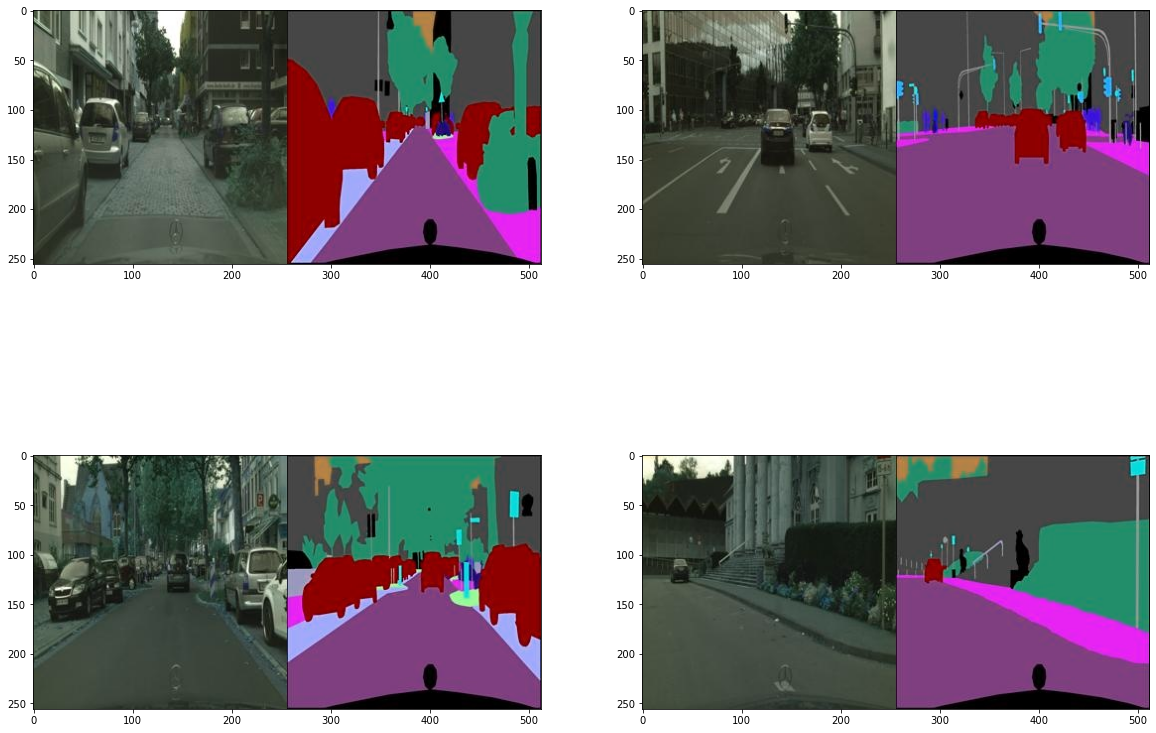

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 5):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(2,2,i)
    plt.imshow(img)

In [4]:
# 이미지 1개 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* 이미지 분할

* augementation  

이미지사이즈만큼 잘라서 50%확률로
1. 가로뒤집기
2. 90도 회전

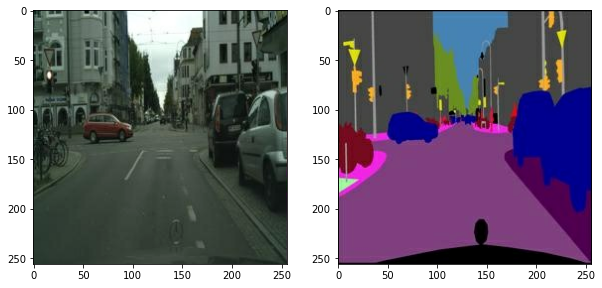

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    base = img[:, :w, :] 
    base = tf.cast(base, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(base), normalize(colored)

f = data_path + os.listdir(data_path)[1]
base, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(base))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(base, colored):
    stacked = tf.concat([base, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    
    if tf.random.uniform(()) < .5:
        out = image.rot90(out)
    
    return out[...,:3], out[...,3:]   

print("done")

done


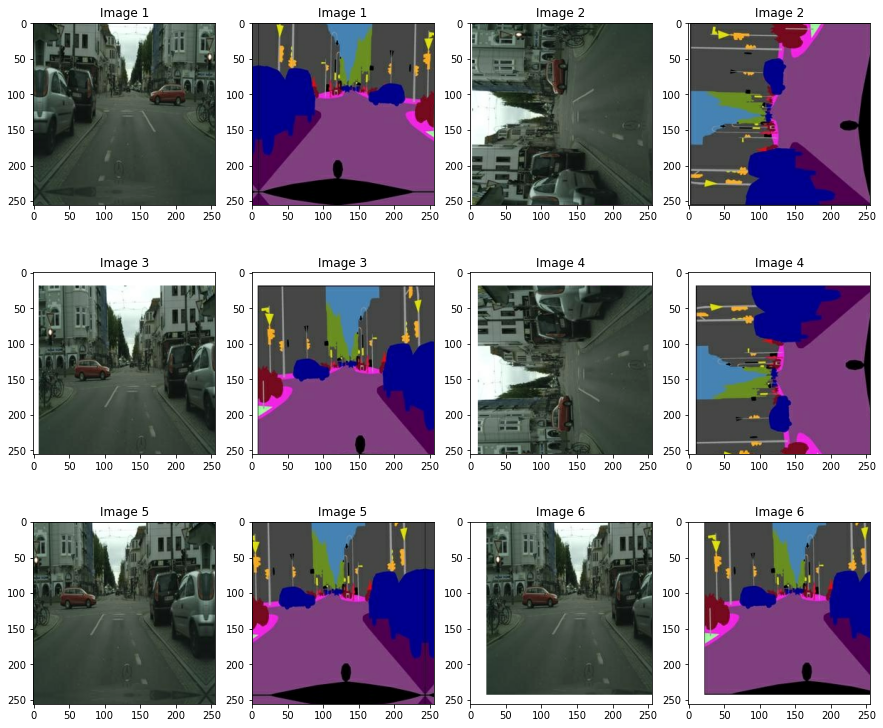

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_base, augmented_colored = apply_augmentation(base, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_base)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [8]:
from tensorflow import data

def get_train(img_path):
    base, colored = load_img(img_path)
    base, colored = apply_augmentation(base, colored)
    return base, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
base, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

* Generator (U-net 구조)

In [9]:
from tensorflow.keras import layers, Input, Model

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("done")

done


In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("done")

done


In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

* Discriminator

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("done")

done


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("done")

done


In [15]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

* test

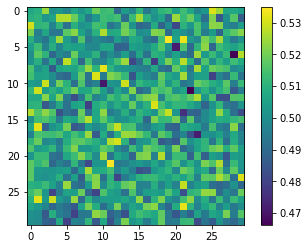

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

* loss

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("done")

done


* optimizer

In [18]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("done")

done


In [19]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [20]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (base, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(base, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9536                     
L1_loss:0.3483                     
Discriminator_loss:1.1712

EPOCH[1] - STEP[20]                     
Generator_loss:1.2343                     
L1_loss:0.2746                     
Discriminator_loss:1.0407

EPOCH[1] - STEP[30]                     
Generator_loss:1.5175                     
L1_loss:0.2448                     
Discriminator_loss:0.7139

EPOCH[1] - STEP[40]                     
Generator_loss:1.7386                     
L1_loss:0.2176                     
Discriminator_loss:0.7316

EPOCH[1] - STEP[50]                     
Generator_loss:1.6630                     
L1_loss:0.2643                     
Discriminator_loss:0.6874

EPOCH[1] - STEP[60]                     
Generator_loss:1.3665                     
L1_loss:0.2921                     
Discriminator_loss:0.5922

EPOCH[1] - STEP[70]                     
Generator_loss:1.3544                     
L1_loss:0.2566                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.3491                     
L1_loss:0.1793                     
Discriminator_loss:0.6691

EPOCH[3] - STEP[80]                     
Generator_loss:0.6857                     
L1_loss:0.2169                     
Discriminator_loss:0.9803

EPOCH[3] - STEP[90]                     
Generator_loss:1.8949                     
L1_loss:0.1945                     
Discriminator_loss:0.6311

EPOCH[3] - STEP[100]                     
Generator_loss:0.8090                     
L1_loss:0.2156                     
Discriminator_loss:0.8900

EPOCH[3] - STEP[110]                     
Generator_loss:1.1129                     
L1_loss:0.2392                     
Discriminator_loss:0.7757

EPOCH[3] - STEP[120]                     
Generator_loss:2.4321                     
L1_loss:0.2211                     
Discriminator_loss:0.6790

EPOCH[3] - STEP[130]                     
Generator_loss:2.3690                     
L1_loss:0.1708                

EPOCH[5] - STEP[130]                     
Generator_loss:0.9795                     
L1_loss:0.1917                     
Discriminator_loss:0.6623

EPOCH[5] - STEP[140]                     
Generator_loss:1.5333                     
L1_loss:0.1958                     
Discriminator_loss:0.4782

EPOCH[5] - STEP[150]                     
Generator_loss:1.7342                     
L1_loss:0.1409                     
Discriminator_loss:0.8335

EPOCH[5] - STEP[160]                     
Generator_loss:2.2760                     
L1_loss:0.1823                     
Discriminator_loss:0.7629

EPOCH[5] - STEP[170]                     
Generator_loss:1.9473                     
L1_loss:0.1503                     
Discriminator_loss:0.4846

EPOCH[5] - STEP[180]                     
Generator_loss:0.5146                     
L1_loss:0.1768                     
Discriminator_loss:1.4533

EPOCH[5] - STEP[190]                     
Generator_loss:1.3246                     
L1_loss:0.1715             

EPOCH[7] - STEP[190]                     
Generator_loss:1.3021                     
L1_loss:0.1649                     
Discriminator_loss:0.4647

EPOCH[7] - STEP[200]                     
Generator_loss:2.0755                     
L1_loss:0.1912                     
Discriminator_loss:0.2997

EPOCH[7] - STEP[210]                     
Generator_loss:1.5206                     
L1_loss:0.1552                     
Discriminator_loss:0.7286

EPOCH[7] - STEP[220]                     
Generator_loss:1.5141                     
L1_loss:0.1827                     
Discriminator_loss:1.1975

EPOCH[7] - STEP[230]                     
Generator_loss:0.9970                     
L1_loss:0.1817                     
Discriminator_loss:0.8971

EPOCH[7] - STEP[240]                     
Generator_loss:1.8969                     
L1_loss:0.1754                     
Discriminator_loss:0.5626

EPOCH[7] - STEP[250]                     
Generator_loss:0.6822                     
L1_loss:0.1771             

EPOCH[9] - STEP[250]                     
Generator_loss:1.7983                     
L1_loss:0.1883                     
Discriminator_loss:0.3893

EPOCH[10] - STEP[10]                     
Generator_loss:0.7086                     
L1_loss:0.1612                     
Discriminator_loss:0.9730

EPOCH[10] - STEP[20]                     
Generator_loss:2.7661                     
L1_loss:0.1996                     
Discriminator_loss:0.5245

EPOCH[10] - STEP[30]                     
Generator_loss:0.7967                     
L1_loss:0.1571                     
Discriminator_loss:1.0363

EPOCH[10] - STEP[40]                     
Generator_loss:0.3758                     
L1_loss:0.1620                     
Discriminator_loss:1.4789

EPOCH[10] - STEP[50]                     
Generator_loss:2.4743                     
L1_loss:0.1720                     
Discriminator_loss:1.7161

EPOCH[10] - STEP[60]                     
Generator_loss:0.6947                     
L1_loss:0.1984             

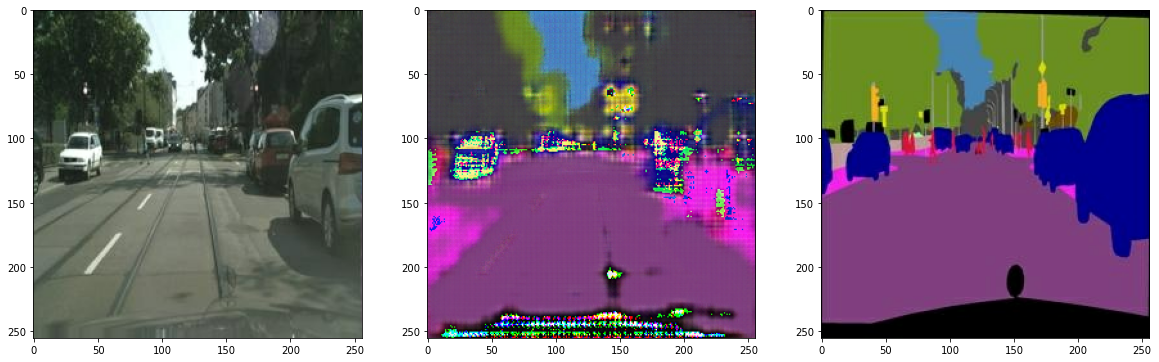

In [25]:
test_ind = 1
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
t = val_path + os.listdir(val_path)[1]
base_1, colored = load_img(t)

pred = generator(tf.expand_dims(base_1, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(base_1))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [ ]:
'''생각보다 형태를 잘 찾아가는 결과를 보였다. 후반부 노드는 과제이후에도 많이 뜯어봐야할거같다.도로는 잘 인식하는걸 보며 자율주행에
활용하기 좋아보인다고 생각해본다.'''